In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
import json
from tqdm import tqdm
from torch.utils.data import DataLoader

# Device configuration: use GPU if available for faster computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load pre-trained ResNet-34 model and set to eval mode
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)  # ImageNet-1K pre-trained weights
model.to(device)
model.eval()

# Define ImageNet normalization (mean and std for 3 channels)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Compose the transforms: resize, crop, tensorize, and normalize
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Load the test dataset (100 classes of ImageNet-1K)
# Assuming images are in 'test_dir' with subfolders per class
test_dir = '/kaggle/input/texsty/TestDataSet'  # <- replace with the actual path to the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Confirm number of test images and classes
num_images = len(test_dataset)
num_classes = len(test_dataset.classes)
print(f"Test dataset: {num_images} images, {num_classes} classes.")


Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s] 


Test dataset: 500 images, 100 classes.


In [2]:

with open(os.path.join(test_dir, "labels_list.json")) as f:
    raw_labels = json.load(f)

imagenet_idxs = list(range(401, 501))
imagenet_idx_to_label = {
    idx: label.split(": ")[1] for idx, label in zip(imagenet_idxs, raw_labels)
}

# Step 5: Build mapping from dataset class index (0–99) to ImageNet label index (401–500)
class_idx_to_imagenet_idx = {i: i + 401 for i in range(100)}

correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        top5_preds = torch.topk(outputs, k=5, dim=1).indices  # [B, 5]

        # 将ImageFolder的class index映射成ImageNet的label index
        imagenet_targets = torch.tensor([class_idx_to_imagenet_idx[t.item()] for t in targets]).to(device)

        for i in range(images.size(0)):
            top5 = top5_preds[i].cpu().tolist()
            if imagenet_targets[i].item() == top5[0]:
                correct_top1 += 1
            if imagenet_targets[i].item() in top5:
                correct_top5 += 1
            total += 1

print(f"Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
print(f"Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")

100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%


task2

In [8]:
# # Task 2 FGSM ε=0.02 (pixel space)

from pathlib import Path
import torch, torch.nn.functional as F, torchvision.transforms as T
import numpy as np, random

epsilon = 0.02
save_root = Path("Adversarial_Test_Set_1")
save_root.mkdir(exist_ok=True, parents=True)

adv_imgs1b, adv_lbls1b, orig_imgs1b = [], [], []
top1 = top5 = total = 0

mean_t = torch.tensor([0.485,0.456,0.406], device=device).view(3,1,1)
std_t  = torch.tensor([0.229,0.224,0.225], device=device).view(3,1,1)

model.eval()
for b, (norm_imgs, labels) in enumerate(test_loader):
    norm_imgs, labels = norm_imgs.to(device), labels.to(device)

    # pixel‑space image & random start within ε‑ball 
    pix = norm_imgs * std_t + mean_t
    pix_orig = pix.clone().detach()
    pix = pix + torch.empty_like(pix).uniform_(-epsilon, epsilon)     # random start
    pix = torch.clamp(torch.max(torch.min(pix, pix_orig+epsilon), pix_orig-epsilon), 0, 1)
    pix.requires_grad = True

    # choose least‑likely class for each sample 
    logits = model((pix-mean_t)/std_t)
    target_cls = logits.argmin(dim=1)         # index of min logit (batch)

    # targeted loss: push toward least
    loss = F.cross_entropy(logits, target_cls)
    model.zero_grad(); loss.backward()

    # targeted FGSM step 
    pix_adv = pix - epsilon * pix.grad.sign()
    pix_adv = torch.clamp(torch.max(torch.min(pix_adv, pix_orig+epsilon), pix_orig-epsilon), 0, 1).detach()

    # save & evaluate 
    for i in range(pix_adv.size(0)):
        cls = test_dataset.classes[labels[i].item()]
        (save_root/cls).mkdir(exist_ok=True, parents=True)
        fname = Path(test_dataset.imgs[b*test_loader.batch_size+i][0]).name
        T.ToPILImage()(pix_adv[i].cpu()).save(save_root/cls/fname)

        adv_imgs1b.append(pix_adv[i].cpu())
        orig_imgs1b.append(pix_orig[i].cpu())
        adv_lbls1b.append(labels[i].cpu())

    with torch.no_grad():
        adv_norm = (pix_adv - mean_t) / std_t
        preds = model(adv_norm)
        _, top5_batch = preds.topk(5, dim=1)
        top1_batch = top5_batch[:,0].cpu().tolist(); top5_batch = top5_batch.cpu().tolist()

        true_idx = [class_idx_to_imagenet_idx[int(l)] for l in labels]
        for k,t in enumerate(true_idx):
            if top1_batch[k] == t: top1 += 1
            if t in top5_batch[k]: top5 += 1
    total += labels.size(0)

print(f"[FGSM ε=0.02]  Top‑1: {100*top1/total:.2f}%   Top‑5: {100*top5/total:.2f}%")

# ε‑verification 
max_linf = max((adv_imgs1b[i] - orig_imgs1b[i]).abs().max().item() for i in range(len(adv_imgs1b)))
print(f"Max ‖adv‑orig‖∞ = {max_linf:.5f}  (≤ 0.02)")

[FGSM ε=0.02]  Top‑1: 7.00%   Top‑5: 21.40%
Max ‖adv‑orig‖∞ = 0.02000  (≤ 0.02)


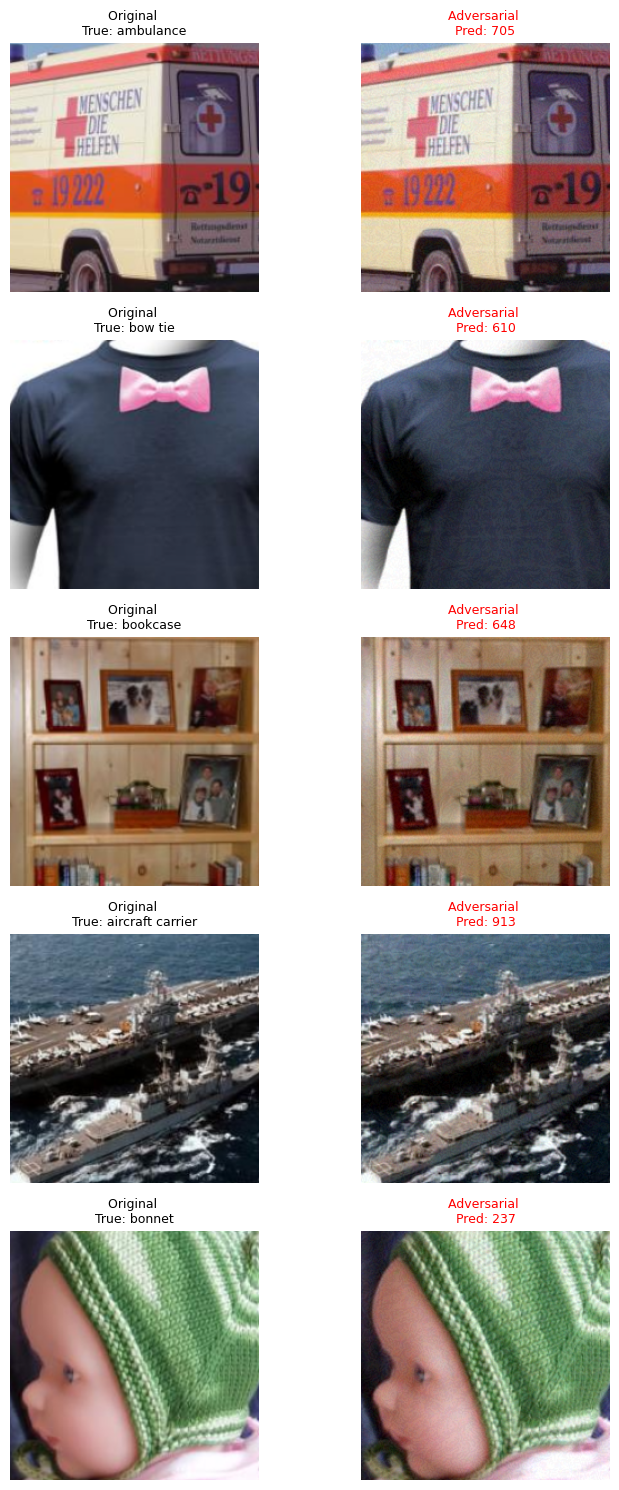

In [7]:
import random, matplotlib.pyplot as plt, torch

# Mean and std vectors shaped as 3×1×1 for broadcasting
mean_vec = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std_vec  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

# Find examples where model predicted correctly on clean but failed on adversarial
mis_idxs = []
with torch.no_grad():
    for i in range(len(adv_imgs1b)):
        ori_pix = test_dataset[i][0] * std_vec + mean_vec      # unnormalize to pixel space
        adv_pix = adv_imgs1b[i]
        ori_pred = model(((ori_pix - mean_vec) / std_vec).unsqueeze(0).to(device)).argmax().item()
        adv_pred = model(((adv_pix - mean_vec) / std_vec).unsqueeze(0).to(device)).argmax().item()
        true_idx = class_idx_to_imagenet_idx[int(adv_lbls1b[i])]
        if ori_pred == true_idx and adv_pred != true_idx:
            mis_idxs.append(i)
    if len(mis_idxs) < 3:
        mis_idxs = random.sample(range(len(adv_imgs1b)), 3)  # fallback if too few mismatches

# Randomly select 5 mismatched examples to visualize
vis_ids = random.sample(mis_idxs, min(5, len(mis_idxs)))
plt.figure(figsize=(8, 3 * len(vis_ids)))
for r, idx in enumerate(vis_ids):
    ori_pix = test_dataset[idx][0] * std_vec + mean_vec     # original image in pixel space
    adv_pix = adv_imgs1b[idx]                                # adversarial image already in pixel space

    true_name = imagenet_idx_to_label[
        class_idx_to_imagenet_idx[int(adv_lbls1b[idx])]
    ]
    with torch.no_grad():
        ori_pred = model(((ori_pix - mean_vec) / std_vec).unsqueeze(0).to(device)).argmax().item()
        adv_pred = model(((adv_pix - mean_vec) / std_vec).unsqueeze(0).to(device)).argmax().item()

    plt.subplot(len(vis_ids), 2, 2 * r + 1)
    plt.imshow(ori_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Original \nTrue: {true_name}", fontsize=9)

    plt.subplot(len(vis_ids), 2, 2 * r + 2)
    plt.imshow(adv_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Adversarial \nPred: {imagenet_idx_to_label.get(adv_pred, str(adv_pred))}",
              fontsize=9, color='red')

plt.tight_layout(); plt.show()



task3

In [11]:

# Task 3 — PGD‑10  (ε = 0.02)

import torch, torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, random

epsilon   = 0.02         # L∞ constraint
alpha     = 0.002        # step size (10 × 0.002 = 0.02)
num_iter  = 10

# ImageNet normalization stats
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
mean_tensor = torch.tensor(imagenet_mean).view(1,3,1,1).to(device)
std_tensor  = torch.tensor(imagenet_std ).view(1,3,1,1).to(device)

# Output directory for saving adversarial images
save_root = Path("Adversarial_Test_Set_2")
save_root.mkdir(exist_ok=True, parents=True)

adv_imgs2, adv_lbls2 = [], []
adv_correct_top1 = adv_correct_top5 = total_adv_samples = 0

model.eval()
for batch_idx, (norm_imgs, labels) in enumerate(test_loader):
    norm_imgs, labels = norm_imgs.to(device), labels.to(device)

    # Convert normalized images to pixel space
    pix_imgs = norm_imgs * std_tensor + mean_tensor
    pix_adv  = pix_imgs.clone().detach()
    pix_orig = pix_imgs.clone().detach()

    true_idx_tensor = torch.tensor(
        [class_idx_to_imagenet_idx[int(l)] for l in labels], device=device
    )

    # PGD iterations 
    for _ in range(num_iter):
        pix_adv.requires_grad = True
        adv_norm = (pix_adv - mean_tensor) / std_tensor
        outputs  = model(adv_norm)
        loss = F.cross_entropy(outputs, true_idx_tensor)
        model.zero_grad(); loss.backward()

        grad_sign = pix_adv.grad.sign()
        pix_adv   = pix_adv + alpha * grad_sign

        # Project perturbation back into ε-ball
        delta = torch.clamp(pix_adv - pix_orig, min=-epsilon, max=epsilon)
        pix_adv = torch.clamp(pix_orig + delta, 0.0, 1.0).detach()

    # Save adversarial examples and compute accuracy
    for i in range(pix_adv.size(0)):
        cls_name = test_dataset.classes[labels[i].item()]
        (save_root/cls_name).mkdir(exist_ok=True, parents=True)
        fname = Path(test_dataset.imgs[batch_idx*test_loader.batch_size+i][0]).name
        T.ToPILImage()(pix_adv[i].cpu()).save(save_root/cls_name/fname)
        adv_imgs2.append(pix_adv[i].cpu())
        adv_lbls2.append(labels[i].cpu())

    # Evaluate model accuracy on adversarial examples
    with torch.no_grad():
        adv_norm_batch = (pix_adv - mean_tensor) / std_tensor
        adv_out = model(adv_norm_batch)
        _, top5 = adv_out.topk(5, dim=1)
        top1 = top5[:,0].cpu().tolist(); top5 = top5.cpu().tolist()
        true_idx_list = [class_idx_to_imagenet_idx[int(l)] for l in labels]
        for k, t in enumerate(true_idx_list):
            if top1[k] == t:   adv_correct_top1 += 1
            if t in top5[k]:   adv_correct_top5 += 1
    total_adv_samples += labels.size(0)

# Report final accuracy
adv_top1_acc = 100 * adv_correct_top1 / total_adv_samples
adv_top5_acc = 100 * adv_correct_top5 / total_adv_samples
print(f"[PGD‑10 ε=0.02]  Top‑1: {adv_top1_acc:.2f}%   Top‑5: {adv_top5_acc:.2f}%")

# Verify L constraint is satisfied
max_linf = 0.0
for i in range(len(adv_imgs2)):
    ori_pix = test_dataset[i][0] * torch.tensor(imagenet_std).view(3,1,1) + torch.tensor(imagenet_mean).view(3,1,1)
    diff = (adv_imgs2[i] - ori_pix).abs().max().item()
    max_linf = max(max_linf, diff)
print(f"Max ‖adv‑orig‖∞ = {max_linf:.5f}  (≤ 0.02)")


[PGD‑10 ε=0.02]  Top‑1: 0.00%   Top‑5: 1.60%
Max ‖adv‑orig‖∞ = 0.02000  (≤ 0.02)


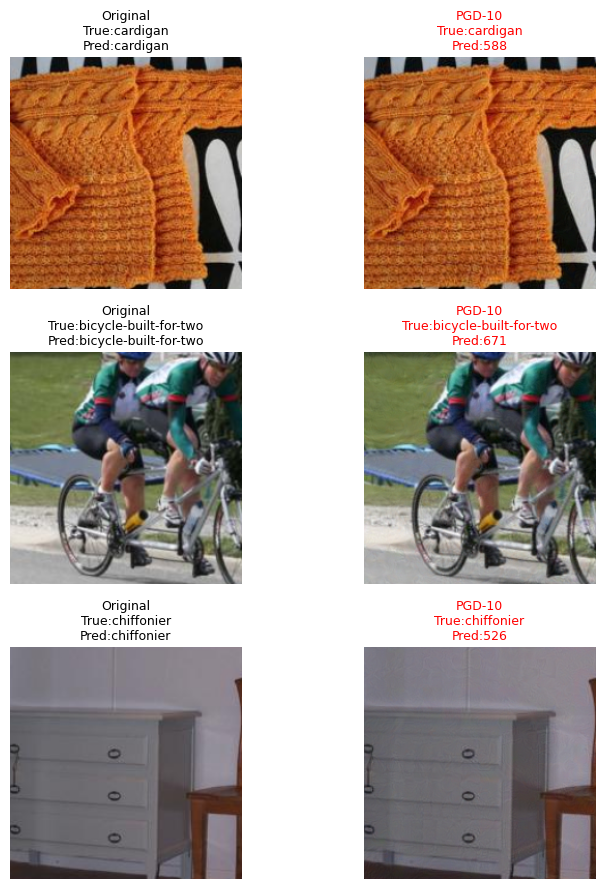

In [12]:
import random, matplotlib.pyplot as plt, numpy as np, torch

mean_vec = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std_vec  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

vis_ids = random.sample(range(len(adv_imgs2)), 3)

plt.figure(figsize=(8, 9))
for row, idx in enumerate(vis_ids):
    ori_norm = test_dataset[idx][0]
    ori_pix  = ori_norm * std_vec + mean_vec
    adv_pix  = adv_imgs2[idx]

    true_idx  = class_idx_to_imagenet_idx[int(adv_lbls2[idx])]
    true_name = imagenet_idx_to_label.get(true_idx, str(true_idx))

    with torch.no_grad():
        ori_pred_idx = model(((ori_pix-mean_vec)/std_vec).unsqueeze(0).to(device)).argmax().item()
        adv_pred_idx = model(((adv_pix-mean_vec)/std_vec).unsqueeze(0).to(device)).argmax().item()

    ori_pred_name = imagenet_idx_to_label.get(ori_pred_idx, str(ori_pred_idx))
    adv_pred_name = imagenet_idx_to_label.get(adv_pred_idx, str(adv_pred_idx))

    plt.subplot(3,2,2*row+1)
    plt.imshow(ori_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Original\nTrue:{true_name}\nPred:{ori_pred_name}", fontsize=9)

    plt.subplot(3,2,2*row+2)
    plt.imshow(adv_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"PGD‑10\nTrue:{true_name}\nPred:{adv_pred_name}", fontsize=9, color='red')

plt.tight_layout(); plt.show()


task4

In [13]:

# Task 4 — Targeted PGD   

# Attack only a random 32×32 patch of each image

epsilon_patch = 0.30
alpha_patch   = 0.03
num_iter      = 10
patch_size    = 32

save_root = Path("Adversarial_Test_Set_3")
save_root.mkdir(exist_ok=True, parents=True)

adv_imgs3, adv_lbls3 = [], []
adv_top1 = adv_top5 = total = 0

model.eval()
for b_idx, (norm_imgs, labels) in enumerate(test_loader):
    norm_imgs, labels = norm_imgs.to(device), labels.to(device)

    pix_imgs = norm_imgs * std_tensor + mean_tensor
    pix_adv  = pix_imgs.clone().detach()
    pix_orig = pix_imgs.clone().detach()

    target_labels = (labels + 1) % 100
    tgt_idx_tensor = torch.tensor(
        [class_idx_to_imagenet_idx[int(t)] for t in target_labels], device=device
    )

    # Generate a random 32×32 binary mask per image
    N, C, H, W = pix_imgs.shape
    mask = torch.zeros_like(pix_imgs)
    for i in range(N):
        y = torch.randint(0, H - patch_size + 1, ()).item()
        x = torch.randint(0, W - patch_size + 1, ()).item()
        mask[i, :, y:y+patch_size, x:x+patch_size] = 1.0

    # Targeted PGD updates 
    for _ in range(num_iter):
        pix_adv.requires_grad = True
        adv_norm = (pix_adv - mean_tensor) / std_tensor
        out = model(adv_norm)
        loss = F.cross_entropy(out, tgt_idx_tensor)
        model.zero_grad(); loss.backward()

        grad = pix_adv.grad.sign() * mask
        pix_adv = pix_adv - alpha_patch * grad

        delta = torch.clamp(pix_adv - pix_orig, -epsilon_patch, epsilon_patch)
        delta = delta * mask
        pix_adv = torch.clamp(pix_orig + delta, 0.0, 1.0).detach()

    # Save and evaluate
    for i in range(N):
        cls = test_dataset.classes[labels[i].item()]
        (save_root/cls).mkdir(exist_ok=True, parents=True)
        fname = Path(test_dataset.imgs[b_idx*test_loader.batch_size+i][0]).name
        T.ToPILImage()(pix_adv[i].cpu()).save(save_root/cls/fname)
        adv_imgs3.append(pix_adv[i].cpu())
        adv_lbls3.append(labels[i].cpu())

    with torch.no_grad():
        adv_norm_batch = (pix_adv - mean_tensor) / std_tensor
        preds = model(adv_norm_batch)
        _, top5 = preds.topk(5, dim=1)
        top1 = top5[:,0].cpu().tolist(); top5 = top5.cpu().tolist()
        true_idx = [class_idx_to_imagenet_idx[int(l)] for l in labels]
        for k, t in enumerate(true_idx):
            if top1[k] == t:   adv_top1 += 1
            if t in top5[k]:   adv_top5 += 1
    total += N

print(f"[Patch Targeted PGD]  Top‑1: {100*adv_top1/total:.2f}%   Top‑5: {100*adv_top5/total:.2f}%")


[Patch Targeted PGD]  Top‑1: 62.80%   Top‑5: 89.20%


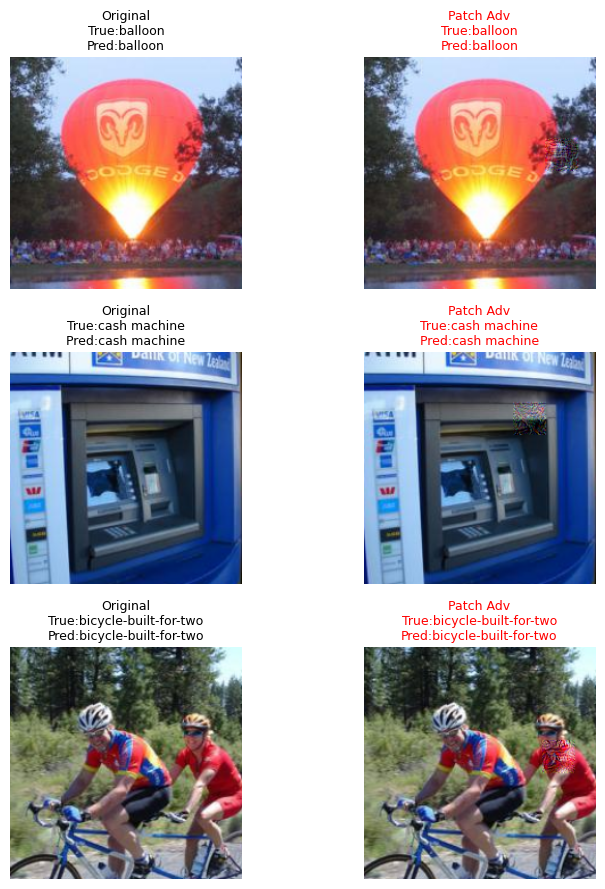

In [14]:
import random, matplotlib.pyplot as plt, numpy as np, torch

mean_vec = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std_vec  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

ids = random.sample(range(len(adv_imgs3)), 3)
plt.figure(figsize=(8,9))
for r, idx in enumerate(ids):
    ori_pix = (test_dataset[idx][0] * std_vec + mean_vec)
    adv_pix = adv_imgs3[idx]

    true_idx  = class_idx_to_imagenet_idx[int(adv_lbls3[idx])]
    true_name = imagenet_idx_to_label.get(true_idx, str(true_idx))

    with torch.no_grad():
        p_ori = model(((ori_pix-mean_vec)/std_vec).unsqueeze(0).to(device)).argmax().item()
        p_adv = model(((adv_pix-mean_vec)/std_vec).unsqueeze(0).to(device)).argmax().item()

    plt.subplot(3,2,2*r+1)
    plt.imshow(ori_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Original\nTrue:{true_name}\nPred:{imagenet_idx_to_label.get(p_ori,str(p_ori))}", fontsize=9)

    plt.subplot(3,2,2*r+2)
    plt.imshow(adv_pix.permute(1,2,0).numpy()); plt.axis('off')
    plt.title(f"Patch Adv\nTrue:{true_name}\nPred:{imagenet_idx_to_label.get(p_adv,str(p_adv))}", fontsize=9, color='red')

plt.tight_layout(); plt.show()


task5

In [15]:

# Task 5 — Evaluate Transferability to DenseNet-121
import torchvision.models as models
import torch.utils.data as data

# Load DenseNet-121 pre-trained on ImageNet-1K
new_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT).to(device)
new_model.eval()

# Build 4 test loaders 
orig_loader = test_loader  # Already normalized

adv_tensor1 = torch.stack(adv_imgs1)
adv_norm1   = (adv_tensor1 - mean_vec) / std_vec
loader1 = data.DataLoader(data.TensorDataset(adv_norm1, torch.tensor(adv_lbls1)),
                          batch_size=32, shuffle=False)

adv_tensor2 = torch.stack(adv_imgs2)
adv_norm2   = (adv_tensor2 - mean_vec) / std_vec
loader2 = data.DataLoader(data.TensorDataset(adv_norm2, torch.tensor(adv_lbls2)),
                          batch_size=32, shuffle=False)

adv_tensor3 = torch.stack(adv_imgs3)
adv_norm3   = (adv_tensor3 - mean_vec) / std_vec
loader3 = data.DataLoader(data.TensorDataset(adv_norm3, torch.tensor(adv_lbls3)),
                          batch_size=32, shuffle=False)

# Evaluation function using label mapping
def eval_loader(net, loader):
    net.eval()
    top1 = top5 = tot = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = net(imgs)
            _, top5_idx = preds.topk(5, dim=1)
            top1_idx = top5_idx[:,0]
            true_idx = torch.tensor([class_idx_to_imagenet_idx[int(l)] for l in lbls]).to(device)
            top1 += (top1_idx == true_idx).sum().item()
            top5 += sum(true_idx[i].item() in top5_idx[i].tolist() for i in range(len(lbls)))
            tot  += len(lbls)
    return 100*top1/tot, 100*top5/tot

# Evaluate across datasets
orig_t1, orig_t5 = eval_loader(new_model, orig_loader)
fgsm_t1, fgsm_t5 = eval_loader(new_model, loader1)
pgd_t1,  pgd_t5  = eval_loader(new_model, loader2)
patch_t1,patch_t5= eval_loader(new_model, loader3)

# Display
print("\n=== DenseNet‑121 Transfer Accuracy ===")
print(f"Clean (Orig)      : Top‑1 {orig_t1:.2f}% | Top‑5 {orig_t5:.2f}%")
print(f"FGSM  (Set 1)     : Top‑1 {fgsm_t1:.2f}% | Top‑5 {fgsm_t5:.2f}%")
print(f"PGD‑10(Set 2)     : Top‑1 {pgd_t1:.2f}% | Top‑5 {pgd_t5:.2f}%")
print(f"Patch  (Set 3)    : Top‑1 {patch_t1:.2f}% | Top‑5 {patch_t5:.2f}%")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 186MB/s]



=== DenseNet‑121 Transfer Accuracy ===
Clean (Orig)      : Top‑1 70.80% | Top‑5 91.20%
FGSM  (Set 1)     : Top‑1 43.20% | Top‑5 67.20%
PGD‑10(Set 2)     : Top‑1 42.80% | Top‑5 78.60%
Patch  (Set 3)    : Top‑1 69.40% | Top‑5 91.00%
